In [1]:
from scipy import stats, integrate, signal
import numpy as np
import matplotlib.pyplot as plt
from typing import Literal, Callable, Tuple
import pickle
from sklearn.neighbors import KernelDensity

In [2]:
from using_kde.precision_recall import _pack, _get_quantile, _prod, _calc_mean, _sort_pair, _get_plotter, _get_modifier

In [3]:
def build_bw_method(scale: float) -> Callable:
    return lambda kde: kde.n**(-1./(kde.d + 4)) * scale

In [4]:
# def kernel(x: float) -> float:
#     # return np.abs(x) < 1.0 # rectangle
#     dot = x@x
#     return 1 - np.sqrt(dot) if dot < 1.0 else 0.0
kernel = signal.windows.triang

In [5]:
def my_kde(data: np.ndarray, xs: np.ndarray, *, h: float = 1.0) -> np.ndarray:
    return np.array([
        sum(kernel((p - x) / h) for p in data) / (h * data.shape[0])
        for x in xs
    ])

In [35]:
def plot_precision(y_act: np.ndarray, y_pred: np.ndarray, quantiles: list[float] = None,
                   plt_mode: Literal['raw', 'subtraction', 'division'] = 'raw',
                   plotter_mode: Literal['plot', 'scatter'] = 'plot',
                   ax: plt.axes = None,
                   quality: int = 1_000,
                   resolution: int = 100,
                   method: Callable = None) -> None:
    quantiles = [0.05, 0.5, 0.95] if quantiles is None else quantiles
    ax = plt.axes() if ax is None else ax

    pred_sp = np.linspace(np.min(y_pred), np.max(y_pred), num=resolution)
    quantiles_sp = np.zeros((len(quantiles), pred_sp.shape[0]))
    mean_sp = np.zeros_like(pred_sp)
    idx = np.zeros_like(pred_sp, dtype=bool)

    points = _prod(pred_sp, np.linspace(np.min(y_act), np.max(y_act), num=quality))

    kde_evs = (stats.
               gaussian_kde(np.vstack([y_act, y_pred]), bw_method=method).
               evaluate(points).
               reshape((-1, quality)))

    points = (points.
              transpose().
              reshape((resolution, quality, -1))
              [:, :, 1].
              copy())

    d = pred_sp[1] - pred_sp[0]
    for j, pred in enumerate(pred_sp):
        if np.min(np.abs(pred - y_pred) > d):
            continue
        idx[j] = True
        u = points[j, :]
        cdf = integrate.cumulative_trapezoid(kde_evs[j, :], u, initial=0.0)
        mean_sp[j] = _calc_mean(kde_evs[j, :] / cdf[-1], u)
        cdf /= cdf[-1]

        for i, q in enumerate(quantiles):
            quantiles_sp[i, j] = _get_quantile(cdf, u, q)

    modifier = _get_modifier(plt_mode, pred_sp)
    plotter = _get_plotter(plotter_mode, ax)

    for i, q in enumerate(quantiles):
        plotter(pred_sp[idx], modifier(quantiles_sp[i, idx]), label=f"{q}-quantile")

    plotter(pred_sp[idx], mean_sp[idx], label="mean", c='r')

    lower_bound = np.full_like(pred_sp, ax.get_ylim()[0])
    ax.scatter(x=pred_sp[~idx], y=lower_bound[~idx], s=1, c='b', label='No data')
    ax.scatter(x=pred_sp[idx], y=lower_bound[idx], s=1, c='r', label='Has data')

    ax.legend()


In [30]:
def plot_pdf(y_act: np.ndarray, 
             y_pred: np.ndarray,
             ax: plt.axes = None, 
             resolution: int = 100, 
             method: Callable | float = None, 
             use_my_kde: bool = False,
             kernel: Literal['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'] = 'gaussian') -> None:
    ax = plt.axes() if ax is None else ax

    arg_sp = np.linspace(min(np.min(y_act), np.min(y_pred)),
                         max(np.max(y_act), np.max(y_pred)),
                         num=resolution)
    if use_my_kde:
        act_kde = np.exp(KernelDensity(kernel=kernel, bandwidth='scott').fit(y_act.reshape((-1, 1))).score_samples(arg_sp.reshape((-1, 1))))
        pred_kde = np.exp(KernelDensity(kernel=kernel, bandwidth='scott').fit(y_pred.reshape((-1, 1))).score_samples(arg_sp.reshape((-1, 1))))
        # act_kde = my_kde(y_act, arg_sp, h=method)
        # pred_kde = my_kde(y_pred, arg_sp, h=method)
    else:
        act_kde = stats.gaussian_kde(y_act, bw_method=method).evaluate(arg_sp)
        pred_kde = stats.gaussian_kde(y_pred, bw_method=method).evaluate(arg_sp)
        
    act_kde /= integrate.trapezoid(act_kde, arg_sp)
    pred_kde /= integrate.trapezoid(pred_kde, arg_sp)

    ax.plot(arg_sp, act_kde,  label="PDF of actual values")
    ax.plot(arg_sp, pred_kde, label="PDF of predicted values")

    ax.legend()

In [31]:
path = 'data.bin'
with open(path, "rb") as f:
    y_act, y_pred = pickle.load(f)

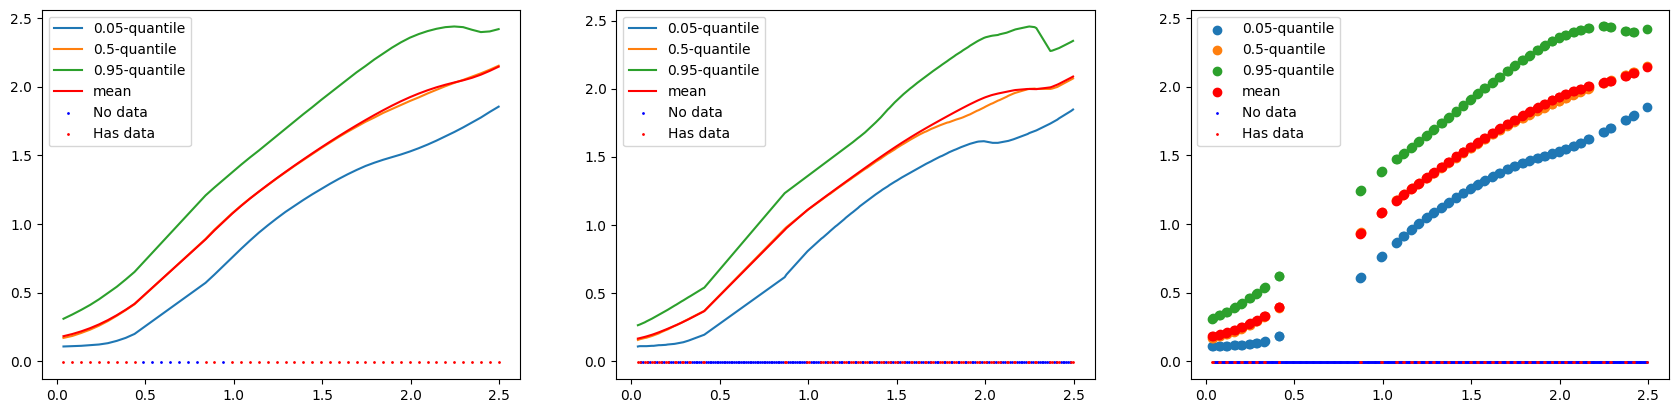

In [36]:
fig, ax = plt.subplots(1, 3)

fig.set_figwidth(21)

plot_precision(y_act, y_pred, resolution=50, ax=ax[0], method=None)
plot_precision(y_act, y_pred, resolution=250, ax=ax[1], method=build_bw_method(0.7466339284926438**2))
plot_precision(y_act, y_pred, resolution=500, ax=ax[2], plotter_mode='scatter')
# plot_precision(y_act, y_pred, resolution=250, ax=ax[2], method=build_bw_method(0.38911245263095356))

In [ ]:
np.linalg.det(np.cov(y_act, y_pred))**0.25

In [ ]:
fig, ax = plt.subplots(2, 3)

for i in range(2):
    for j in range(3):
        ax[i, j].set_ylim((0, 1))

fig.set_figwidth(21)
fig.set_figheight(14)

plot_pdf(y_act, y_pred, resolution=250, ax=ax[0, 0], method=None)
plot_pdf(y_act, y_pred, resolution=250, ax=ax[0, 1], method=build_bw_method(0.7466339284926438))
plot_pdf(y_act, y_pred, resolution=250, ax=ax[0, 2], method=build_bw_method(0.7466339284926438**2))
# plot_pdf(y_act, y_pred, resolution=250, ax=ax[2], method=build_bw_method(0.38911245263095356))
plot_pdf(y_act, y_pred, resolution=250, ax=ax[1, 0], method=1.0, use_my_kde=True)
plot_pdf(y_act, y_pred, resolution=250, ax=ax[1, 1], method=0.5, use_my_kde=True, kernel='tophat')
plot_pdf(y_act, y_pred, resolution=250, ax=ax[1, 2], method=0.25, use_my_kde=True, kernel='epanechnikov')

In [ ]:
fig, ax = plt.subplots(1, 2)

fig.set_figwidth(14)

ax[0].hist(y_act, bins=np.linspace(0, 2.5, num=15), edgecolor="red", color="blue")
ax[1].hist(y_pred, bins=np.linspace(0, 2.5, num=15), edgecolor="red", color="orange")

In [ ]:
pupa = np.linspace(-2, 2, num=50)
window = signal.windows.triang(10)
window